# XGBoost for Price 4

## Introduction

    * Given prices and other features for the last N months, we do prediction for month N+1
    * Here we split 30 years of data into train(50%), dev(10%) and test(40%)
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets
    * Here for the past N values for the dev set, we scale them to have mean 0 and variance 1, and do prediction on them
    * Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns)

In [25]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input ######

test_size = 0.4                # proportion of dataset to be used as test set
cv_size = 0.1                  # proportion of dataset to be used as cross-validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0
model_seed = 100
fontsize = 14
ticklabelsize = 14

# Functions

In [26]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Data Input

In [27]:
df = pd.read_csv("../Data/XGBoost_All.csv")
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df['month'] = df['date'].dt.month
df.sort_values(by='date', inplace=True, ascending=True)
df.drop(["sent^_","sent"],axis=1,inplace=True)
df.head()

,date,price1,price2,price3,price4,price5,yr2,yr3,yr4,yr5,...,pce_defl:_nondble,pce_defl:_service,ahe:_goods,ahe:_const,ahe:_mfg,consumer_expect,finan_h1,marco_h1,bw,month
0,1969-12-01,92.289,85.023,78.311,72.049,67.126,-1.922240,-4.545185,-5.919625,-7.607632,...,27.7995,18.3032,3.40,4.51,3.15,78.3,1.078593,0.641486,NaN,12
1,1970-01-01,92.332,85.221,78.489,72.344,66.798,-1.813144,-4.104810,-7.004857,-8.146208,...,27.9188,18.3809,3.41,4.54,3.16,77.1,1.101297,0.666907,-1.007605,1
2,1970-02-01,93.333,86.870,80.967,75.074,69.950,-0.976535,-1.617116,-3.052377,-3.848165,...,28.0357,18.4596,3.43,4.56,3.17,75.8,1.120442,0.662006,0.690599,2
3,1970-03-01,93.607,87.098,81.405,75.202,70.288,-1.108279,-1.859145,-2.604972,-3.644531,...,28.0382,18.5488,3.45,4.60,3.19,74.3,1.155210,0.661063,0.009687,3
4,1970-04-01,92.786,85.959,79.285,73.154,67.907,-1.520870,-3.004423,-5.578124,-6.409783,...,28.2254,18.6378,3.47,4.66,3.19,72.7,1.232648,0.668466,0.450066,4


In [28]:
df = df.iloc[:-60,:]

Text(0, 0.5, 'USD')

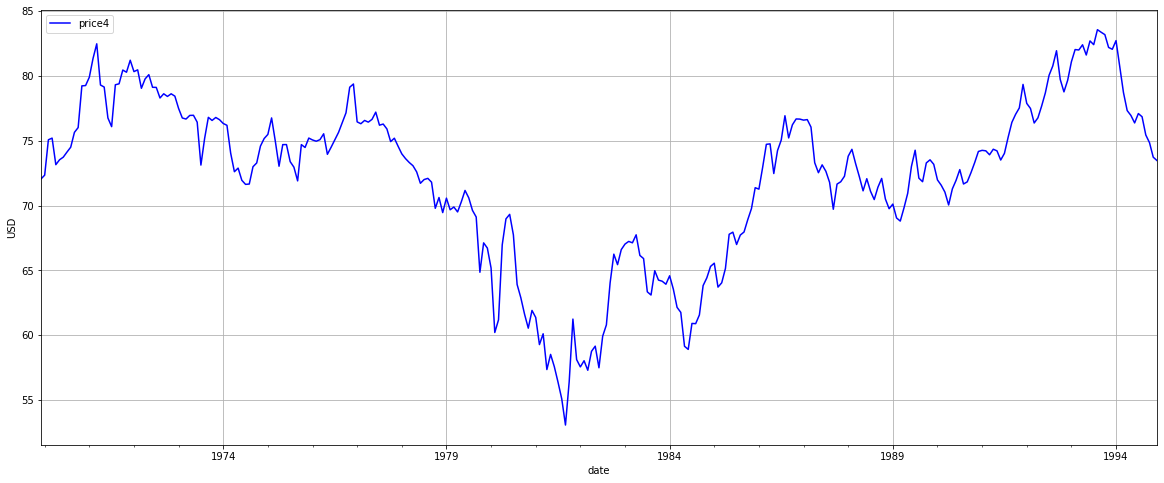

In [29]:
# Plot
rcParams['figure.figsize'] = 20, 8 # width 10, height 8
ax = df.plot(x='date', y='price4', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'price4' of each month
* Use PCA to compress correlation

Now we use lags up to N number of days to use as features.

In [30]:
df['id'] = [x for x in list(range(len(df)))]
pca=PCA(n_components=1)
df_factor = df.iloc[:,12:-1]
df_factor.drop(['month'],axis=1,inplace=True)
count = 0
while(((df_factor.corr()>0.8).sum()-1).sum()>0):
    count +=1
    i = 0
    while(not ((df_factor.corr()>0.8).sum()-1)[i]>0):
        i+=1
    temp_l = list((df_factor.corr()>0.8).iloc[i,:])
    pca_l =[]
    for j in range(len(temp_l)):
        if temp_l[j]:
            pca_l.append(df_factor.columns[j])
    pca_l=list(set(pca_l))
    temp_df=pca.fit_transform(df_factor.loc[:,pca_l])
    df_factor.drop(pca_l,axis=1,inplace=True)
    df_factor["PCA"+str(count)] = temp_df
    print(str(count)+" ",end="")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [31]:
df.index = df['date']
df_factor.index = df['date']
df = pd.concat([df.loc[:,["price4","date","month","id"]],df_factor],axis=1).iloc[1:,:]
df.head()

,price4,date,month,id,f2,f3,f4,f7,f8,r15-r11,...,PCA17,PCA18,PCA19,PCA20,PCA23,PCA25,PCA26,PCA27,PCA28,PCA29
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,72.344,1970-01-01,1,1,1.83830,-0.10564,0.32657,-1.14040,-0.66347,58.205291,...,1238.644518,-146.596267,286.906636,0.015166,-87.170311,1.715049,3.762603,138.480720,980.670224,-668.303741
1970-02-01,75.074,1970-02-01,2,2,0.97842,0.75592,0.30007,-0.52714,1.48290,24.116042,...,1088.644518,-148.032935,245.250976,0.199347,-77.721060,1.514022,4.618818,138.454967,-471.874787,-454.392625
1970-03-01,75.202,1970-03-01,3,3,0.30629,-0.15847,0.92243,0.44476,0.10178,61.059852,...,1060.644517,-148.971626,245.232801,0.371970,-29.326719,0.565204,2.685515,138.288681,322.730474,-443.486592
1970-04-01,73.154,1970-04-01,4,4,1.16570,-0.33656,-0.84470,0.32372,0.64264,137.386472,...,899.644516,-151.760528,-27.663524,0.722382,-55.886958,0.545706,3.151919,138.762376,2123.184663,-400.421168
1970-05-01,73.532,1970-05-01,5,5,0.71366,1.77200,-0.80034,0.35286,3.00860,-3.124063,...,929.644518,-152.816264,-334.685322,0.773940,-44.955827,0.484677,1.789698,139.585018,1433.573236,-290.867838


# Get mean and std dev at t using values from t-1, ..., t-N

In [34]:
cols_list = [
"price4",
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,price4,date,month,id,f2,f3,f4,f7,f8,r15-r11,...,PCA19,PCA20,PCA23,PCA25,PCA26,PCA27,PCA28,PCA29,price4_mean,price4_std
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,72.344,1970-01-01,1,1,1.83830,-0.10564,0.32657,-1.14040,-0.66347,58.205291,...,286.906636,0.015166,-87.170311,1.715049,3.762603,138.480720,980.670224,-668.303741,NaN,NaN
1970-02-01,75.074,1970-02-01,2,2,0.97842,0.75592,0.30007,-0.52714,1.48290,24.116042,...,245.250976,0.199347,-77.721060,1.514022,4.618818,138.454967,-471.874787,-454.392625,72.344000,NaN
1970-03-01,75.202,1970-03-01,3,3,0.30629,-0.15847,0.92243,0.44476,0.10178,61.059852,...,245.232801,0.371970,-29.326719,0.565204,2.685515,138.288681,322.730474,-443.486592,73.709000,1.930402
1970-04-01,73.154,1970-04-01,4,4,1.16570,-0.33656,-0.84470,0.32372,0.64264,137.386472,...,-27.663524,0.722382,-55.886958,0.545706,3.151919,138.762376,2123.184663,-400.421168,74.206667,1.614386
1970-05-01,73.532,1970-05-01,5,5,0.71366,1.77200,-0.80034,0.35286,3.00860,-3.124063,...,-334.685322,0.773940,-44.955827,0.484677,1.789698,139.585018,1433.573236,-290.867838,74.476667,1.147249


# Split into train, dev and test set

In [35]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 150
num_cv = 30
num_test = 120
train.shape = (150, 68)
cv.shape = (30, 68)
train_cv.shape = (180, 68)
test.shape = (120, 68)


# Scaling

In [36]:
cols_to_scale = ["price4"]+list(df.columns[4:])

In [37]:
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])



# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled.index = train.index
train_scaled.head()

,price4,f2,f3,f4,f7,f8,r15-r11,cp_factor,smb,agric,...,PCA19,PCA20,PCA23,PCA25,PCA26,PCA27,PCA28,PCA29,price4_mean,price4_std
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,0.020153,1.042445,-0.113990,0.202438,-1.695445,-0.705347,1.039692,0.118004,0.808056,0.070178,...,-0.031980,-0.689542,-0.883477,0.109635,0.488565,1.725969,1.215295,-1.089410,NaN,NaN
1970-02-01,0.420086,0.400697,0.650149,0.182468,-1.021463,1.447242,0.317141,0.020814,-0.838934,1.257010,...,-0.059658,-0.448103,-0.820751,0.072279,0.683865,1.725437,-0.646979,-0.780858,-0.008149,NaN
1970-03-01,0.438837,-0.100929,-0.160846,0.651473,0.046669,0.062120,1.100197,0.350701,-0.819828,-2.096322,...,-0.059670,-0.221815,-0.499498,-0.104037,0.242886,1.721996,0.371766,-0.765127,0.199393,1.250278
1970-04-01,0.138814,0.540469,-0.318799,-0.680222,-0.086355,0.604547,2.718005,0.636585,-2.040411,-2.805410,...,-0.240998,0.237532,-0.675811,-0.107660,0.349271,1.731798,2.680087,-0.703008,0.275061,0.841507
1970-05-01,0.194190,0.203101,1.551335,-0.646792,-0.054330,2.977363,-0.260237,-0.182210,-1.518402,-1.705726,...,-0.445001,0.305117,-0.603248,-0.119001,0.038553,1.748821,1.795952,-0.544985,0.316114,0.237260


In [38]:
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])

train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled.index = train_cv.index
train_cv_scaled.head()

,price4,f2,f3,f4,f7,f8,r15-r11,cp_factor,smb,agric,...,PCA19,PCA20,PCA23,PCA25,PCA26,PCA27,PCA28,PCA29,price4_mean,price4_std
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,0.217673,1.184578,-0.112793,0.207309,-1.747264,-0.681253,0.993403,-0.072899,0.841661,0.046275,...,0.079096,-0.651904,-0.691454,0.067155,0.646967,1.932239,1.290980,-1.187113,NaN,NaN
1970-02-01,0.605488,0.535645,0.694283,0.186173,-1.054503,1.492202,0.263436,-0.164921,-0.876389,1.291397,...,0.050902,-0.422441,-0.629391,0.026798,0.849091,1.931679,-0.631425,-0.861261,0.208867,NaN
1970-03-01,0.623671,0.028404,-0.162282,0.682553,0.043391,0.093654,1.054529,0.147423,-0.856459,-2.226632,...,0.050890,-0.207377,-0.311540,-0.163686,0.392701,1.928062,0.420214,-0.844648,0.404992,1.273614
1970-04-01,0.332739,0.676981,-0.329109,-0.726869,-0.093340,0.641339,2.688941,0.418104,-2.129706,-2.970547,...,-0.133820,0.229185,-0.485986,-0.167601,0.502804,1.938365,2.803067,-0.779046,0.476498,0.851077
1970-05-01,0.386436,0.335837,1.646106,-0.691489,-0.060422,3.037155,-0.319867,-0.357147,-1.585173,-1.816853,...,-0.341627,0.293418,-0.414191,-0.179853,0.181228,1.956258,1.890385,-0.612163,0.515292,0.226481


In [39]:
train_scaled = train_cv_scaled[:150]
cv_scaled = train_cv_scaled[150:]

In [40]:
scaler_test = StandardScaler()
test_scaled = scaler_train_cv.fit_transform(test[cols_to_scale])

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)
test_scaled.index = test.index
test_scaled.head()

,price4,f2,f3,f4,f7,f8,r15-r11,cp_factor,smb,agric,...,PCA19,PCA20,PCA23,PCA25,PCA26,PCA27,PCA28,PCA29,price4_mean,price4_std
date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-2.011217,-0.442953,-0.849506,0.388262,0.150268,-1.605408,-3.305562,1.995667,1.424258,0.317089,...,1.030950,1.411730,-1.452275,0.940711,-0.873891,2.966721,-1.789433,1.194698,-2.159999,-0.191163
1985-02-01,-2.429925,-0.333956,-0.451918,-1.247993,1.045295,-1.684951,-0.324928,1.956565,0.396731,0.830458,...,0.950826,1.602368,-2.474007,1.101239,-0.923933,3.135955,-0.173699,1.079810,-2.032372,-0.543687
1985-03-01,-2.354847,-0.138628,0.647395,-0.173746,0.150280,0.442589,0.493670,2.277873,-0.410957,0.050168,...,0.956823,1.160684,-0.397370,1.207765,-1.253354,3.067203,0.420175,1.476748,-2.085076,0.418389
1985-04-01,-2.104439,-1.473015,-1.211123,1.981225,0.228555,0.974550,0.555063,2.067184,0.143329,0.758104,...,0.893873,1.162538,-0.971125,1.000522,-1.073617,2.903860,0.335639,1.404172,-2.178379,0.378233
1985-05-01,-1.506317,-1.800924,-0.319032,1.418024,0.488587,-0.055549,-0.924685,2.245087,-0.911736,0.493678,...,0.856476,1.248202,-0.566129,0.793525,-0.792461,2.900911,-0.770412,1.201434,-2.208717,-0.172558


In [41]:
train_scaled['date'] = train_scaled.index
train_cv_scaled['date'] = train_cv_scaled.index
cv_scaled['date'] = cv_scaled.index
test_scaled['date'] = test_scaled.index

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# Split into X and y
features = train_scaled.columns[1:]
target = "price4"
# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (150, 65)
y_train.shape = (150,)
X_cv.shape = (30, 65)
y_cv.shape = (30,)
X_train_cv.shape = (180, 65)
y_train_cv.shape = (180,)
X_sample.shape = (120, 65)
y_sample.shape = (120,)


In [43]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (150, 65)
y_train_scaled.shape = (150,)
X_cv_scaled.shape = (30, 65)
X_train_cv_scaled.shape = (180, 65)
y_train_cv_scaled.shape = (180,)
X_sample_scaled.shape = (120, 65)


# Plot of the 'price4'

Text(0.5, 1.0, 'Without scaling')

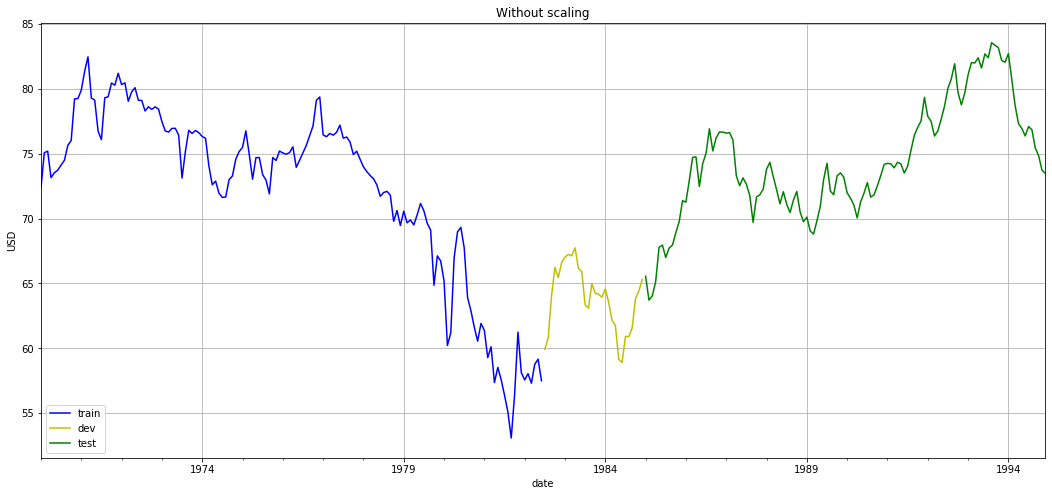

In [44]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train.plot(x='date', y='price4', style='b-', grid=True)
ax = cv.plot(x='date', y='price4', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price4', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

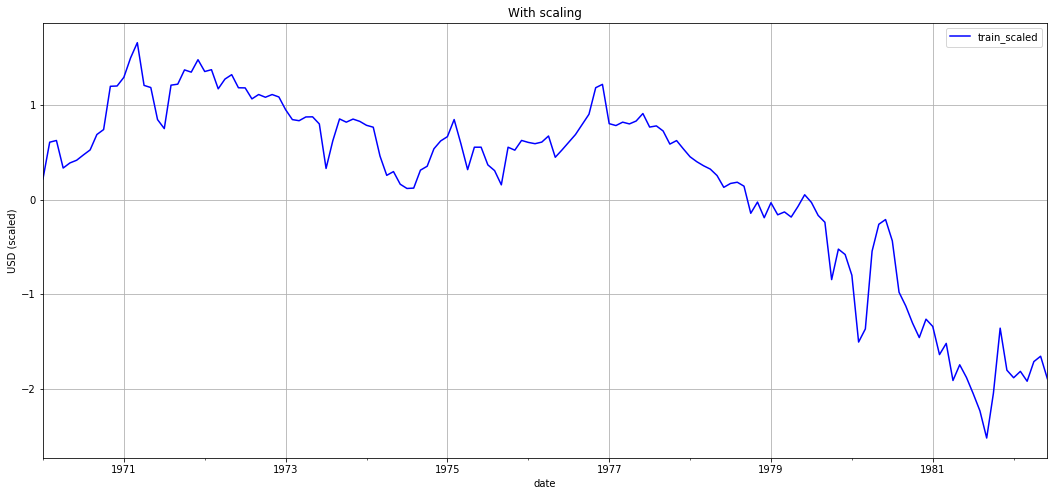

In [45]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='price4', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [46]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)
X_train_scaled.drop(['date'],axis=1,inplace=True)
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

# Predict on train set

In [47]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 1.378
MAPE on train set = 1.926%


Text(0.5, 1.0, 'Without scaling')

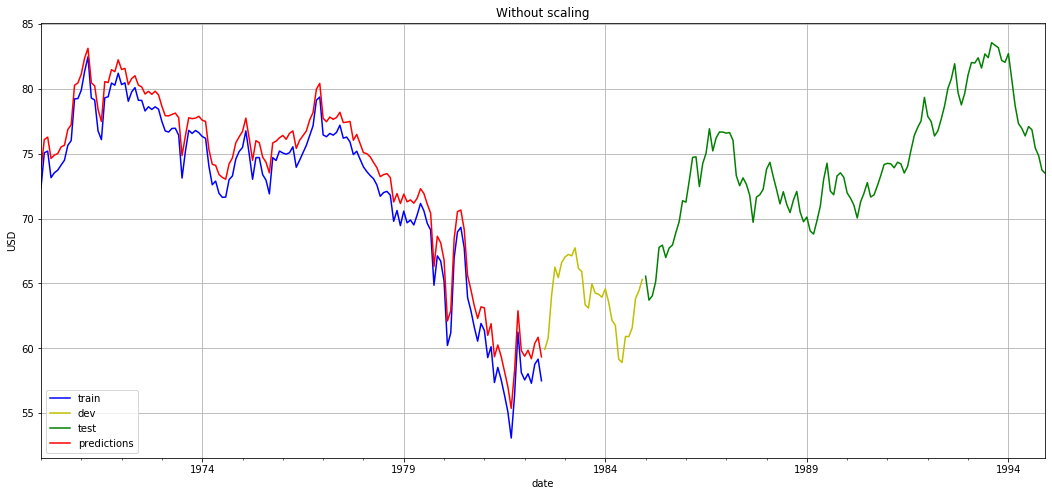

In [48]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='price4', style='b-', grid=True)
ax = cv.plot(x='date', y='price4', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price4', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [49]:
# Do prediction on test set
X_cv_scaled.drop(['date'],axis=1,inplace=True)
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['price4_std'] + cv['price4_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

RMSE on dev set = 2.938
MAPE on dev set = 3.502%


Text(0, 0.5, 'USD')

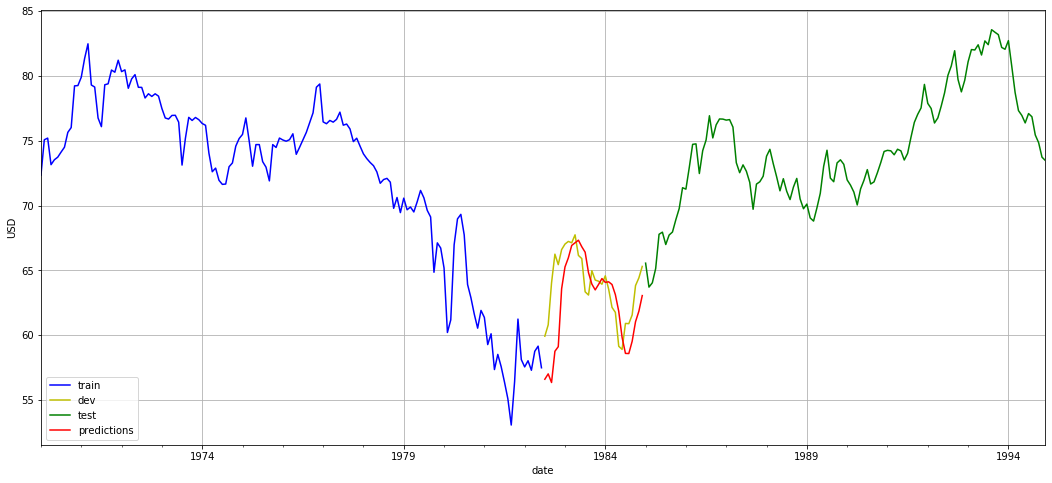

In [50]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='price4', style='b-', grid=True)
ax = cv.plot(x='date', y='price4', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price4', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

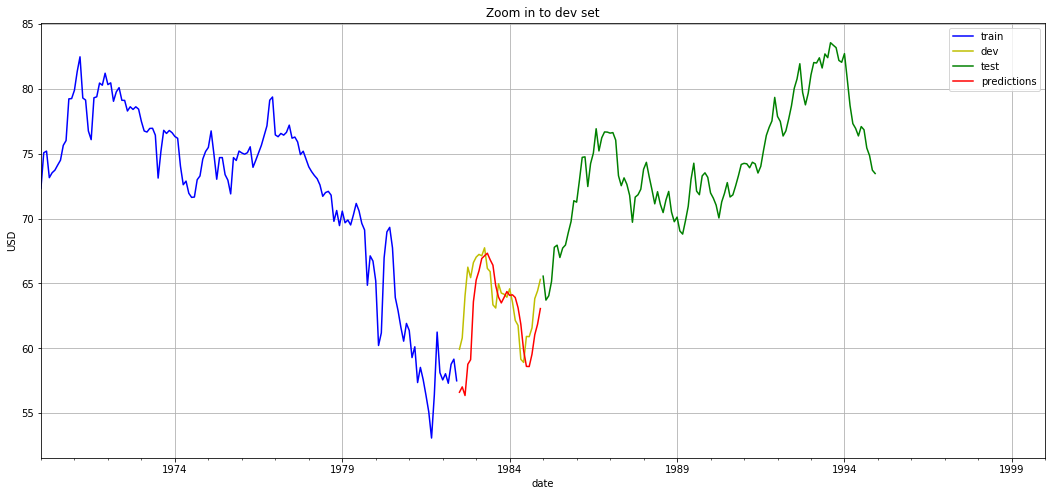

In [51]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8
ax = train.plot(x='date', y='price4', style='b-', grid=True)
ax = cv.plot(x='date', y='price4', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price4', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(1970, 1, 1), date(2000, 1, 1)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

In [52]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('PCA25', 0.006941737),
 ('ip:_fuels', 0.007879175),
 ('ex_rate:_avg', 0.008290261),
 ('orders:_cap_gds', 0.013652405),
 ('spot_market_price', 0.014134633),
 ('PCA9', 0.02075884),
 ('inst_cred/pi', 0.03619563),
 ('PCA12', 0.043040268),
 ('price4_mean', 0.048944566),
 ('PCA18', 0.74826384)]

# Tuning N (no. of days to use as features)

In [53]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


Use N = 3 for lowest RMSE and MAPE

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [54]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price4_mean'],
                                     cv['price4_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 1.1153553287188211


,n_estimators,max_depth,rmse,mape_pct
0,10,2,2.443201,3.051467
1,10,3,2.524557,3.081308
2,10,4,2.535649,3.060930
3,10,5,2.524614,3.065855
4,10,6,2.525102,3.063832
...,...,...,...,...
235,300,5,2.961017,3.492847
236,300,6,2.937387,3.482403
237,300,7,2.935145,3.485818
238,300,8,2.941378,3.481708


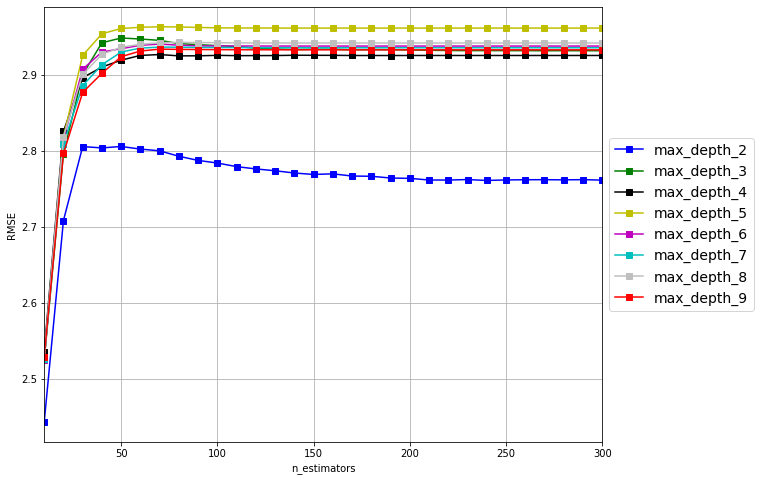

In [55]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [56]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2.443
optimum params = 


(10, 2)

In [57]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 3.051%
optimum params = 


(10, 2)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [58]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price4_mean'],
                                     cv['price4_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:41:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 0.046343572934468585


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,1.865844,2.266842
1,0.001,6,1.865844,2.266842
2,0.001,7,1.865844,2.266842
3,0.001,8,1.865844,2.266842
4,0.001,9,1.865844,2.266842
...,...,...,...,...
107,0.300,16,2.633934,3.251396
108,0.300,17,2.838411,3.415047
109,0.300,18,2.845845,3.418490
110,0.300,19,2.871796,3.445151


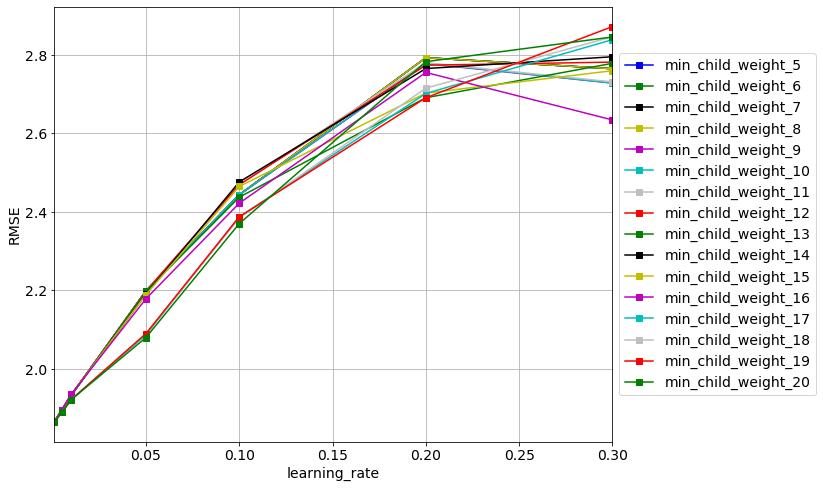

In [59]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [60]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.865
optimum params = 


(0.001, 17)

In [61]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 2.266%
optimum params = 


(0.001, 17)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [62]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price4_mean'],
                                     cv['price4_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 0.04365725914637248


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,1.858845,2.256547
1,0.1,0.2,1.858845,2.256547
2,0.1,0.3,1.858845,2.256547
3,0.1,0.4,1.858845,2.256547
4,0.1,0.5,1.858845,2.256547
...,...,...,...,...
95,1.0,0.6,1.864847,2.265551
96,1.0,0.7,1.864847,2.265551
97,1.0,0.8,1.864847,2.265551
98,1.0,0.9,1.864847,2.265551


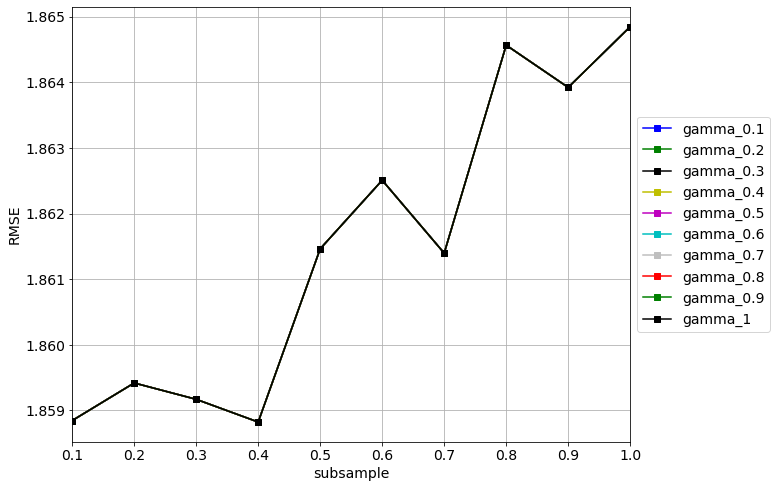

In [63]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [64]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.859
optimum params = 


(0.4, 0.1)

In [65]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 2.257%
optimum params = 


(0.1, 0.1)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [66]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price4_mean'],
                                     cv['price4_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 0.010588335990905761


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,1.860263,2.260980
1,0.5,0.6,1.860877,2.261142
2,0.5,0.7,1.860258,2.261209
3,0.5,0.8,1.860258,2.261209
4,0.5,0.9,1.860048,2.261218
5,0.5,1.0,1.859702,2.261439
6,0.6,0.5,1.859726,2.261603
7,0.6,0.6,1.860119,2.262193
8,0.6,0.7,1.860119,2.262193
9,0.6,0.8,1.860055,2.262133


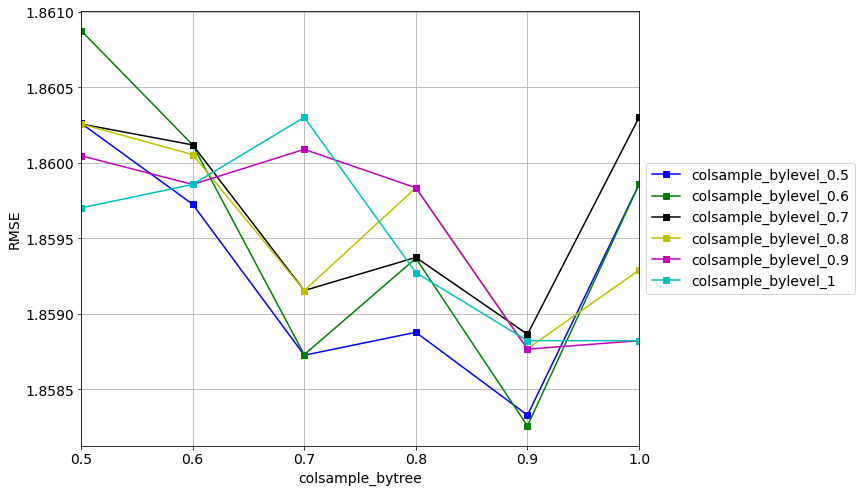

In [67]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [68]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.858
optimum params = 


(0.9, 0.6)

In [69]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 2.259%
optimum params = 


(0.9, 0.6)

# Tuned params

In [70]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,10.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.001
3,min_child_weight,1.000,17.000
4,subsample,1.000,0.400
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,0.600
7,gamma,0.000,0.100
8,rmse,2.938,1.858
9,mape_pct,3.502,2.259


# Final model

In [71]:
X_sample_scaled.drop(["date"],axis=1,inplace=True)

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [72]:
X_train_cv_scaled.drop(["date"],axis=1,inplace=True)

In [73]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['price4_mean'],
                             test['price4_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt,
                             max_depth=max_depth_opt,
                             learning_rate=learning_rate_opt,
                             min_child_weight=min_child_weight_opt,
                             subsample=subsample_opt,
                             colsample_bytree=colsample_bytree_opt,
                             colsample_bylevel=colsample_bylevel_opt,
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lenovo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:42:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 1.484
MAPE on test set = 1.595%


Text(0, 0.5, 'USD')

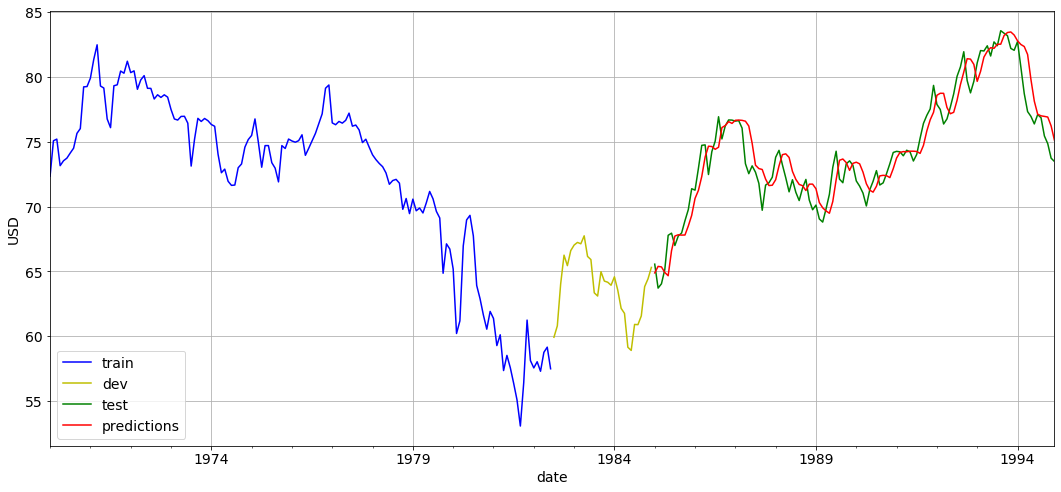

In [74]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='price4', style='b-', grid=True)
ax = cv.plot(x='date', y='price4', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price4', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

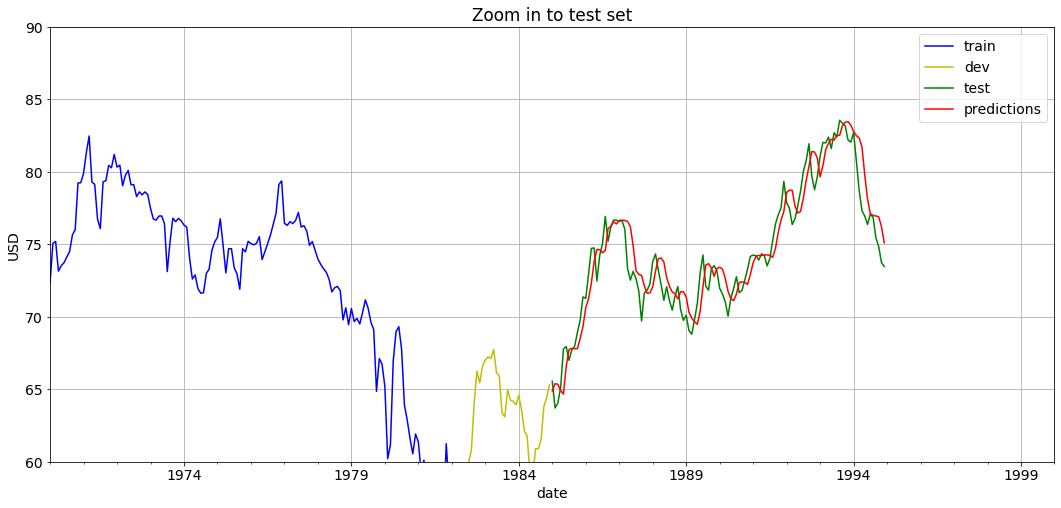

In [75]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8
ax = train.plot(x='date', y='price4', style='b-', grid=True)
ax = cv.plot(x='date', y='price4', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price4', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(1970, 1, 1), date(2000, 1, 1)])
ax.set_ylim([60, 90])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

Using matplotlib backend: Qt5Agg


(70, 90)

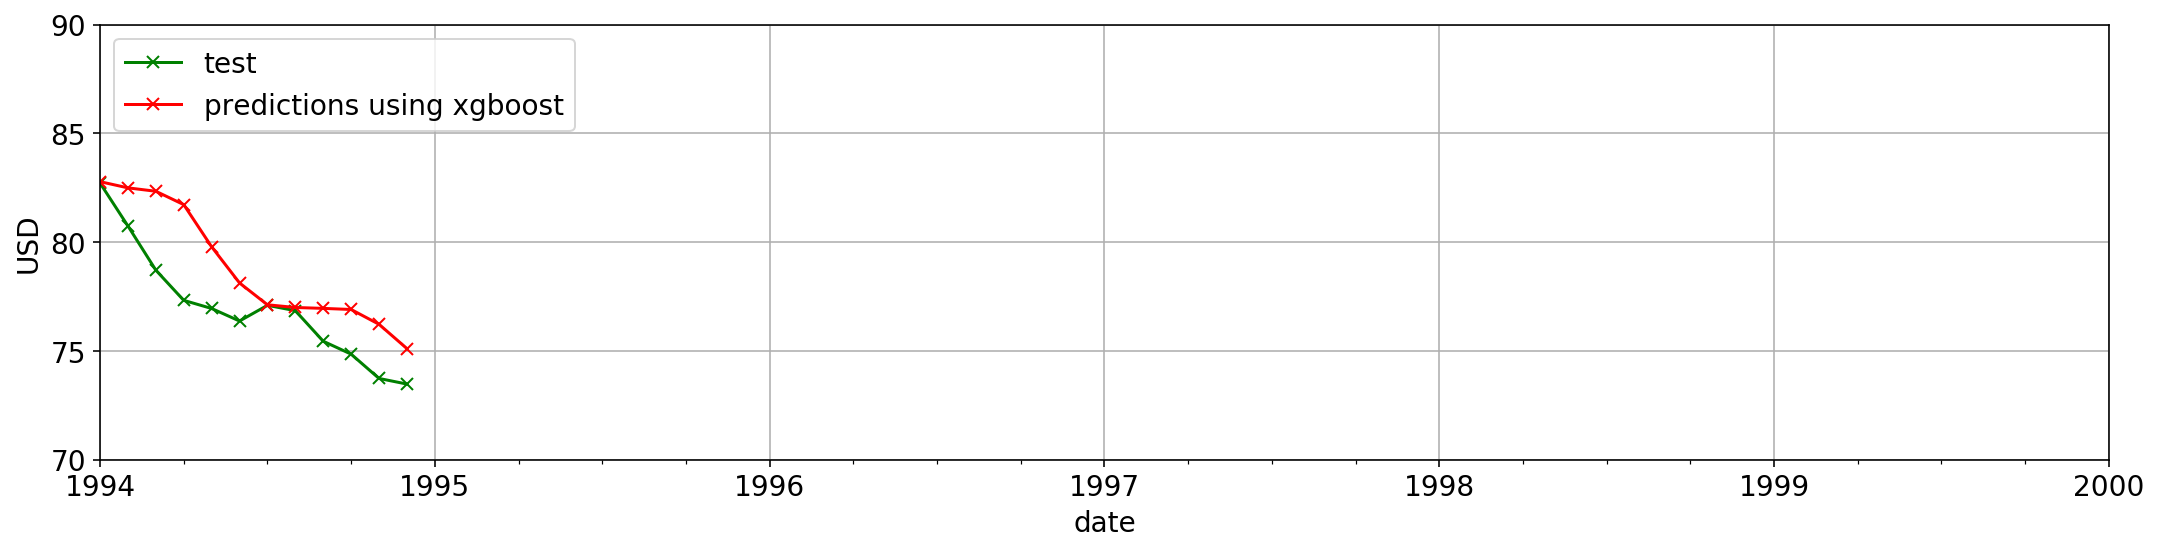

In [76]:
# Plot
%matplotlib auto
rcParams['figure.figsize'] = 18, 4 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='price4', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(1994, 1, 1), date(2000, 1, 1)])
ax.set_ylim([70, 90])

In [77]:
# Save as csv
test_xgboost = est_df
test_xgboost.to_csv("Out/D1M_F1M_1985-1995_price4_xgboost.csv")

# Findings
* By scaling the features properly, we can get good results for our predictions